# A Probabilistic Approach  

In [1]:
import os
import gzip
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

from trainer import *
# The experiment for tuning and searching can be found in the notebook:
# https://colab.research.google.com/drive/1CXthH4dujMu475C-9G9FyLul6Ritrts1?usp=sharing
# (the code has not been optimized for readability)

## 0 Motivation

In fields like finance and medicine, it is often insufficient to provide a single point estimate of certain values: the desired estimations should come with a probability or confidence level, in order to answer questions like: 
- How sure are we to make this prediction? 
  
- What is the probability that the actual value is higher than our estimate? 
  
- What is the probability for the case where it is lower?    

Therefore, it is natural to consider probabilistic machine learning techniques for tasks like these. Probabilistic methods allow us to take both **epistemic uncertainty** and **aleatoric uncertainty** into consideration, where epistemic uncertainty describes the uncertainty that are due to things one could in principle know but does not in practice (*e.g.* it is impossible to achieve zero measurement error) and aleatoric uncertainty refers to the data's inherent randomness (*e.g.* the data are generated from a random process).   

We first get the data and view it.

In [10]:
parent_path = str(pathlib.Path(os.getcwd()).parent)
df = viewData(parent_path)
df.sample(5)

,optionid,securityid,strike,callput,date_traded,contract_price,market_price,underlyings_price,contract_volume,days_to_maturity,moneyness,rate,volatility
90660,163311271.0,702263.0,16.50,C,2018-10-10,0.0870,0.090,15.945500,143.0,37.0,0.966394,0.023185,0.120411
76559,161071371.0,702263.0,14.30,C,2016-09-14,0.2275,0.215,14.095000,169.0,37.0,0.985664,0.005697,0.093564
39014,155067308.0,701057.0,190.00,C,2013-01-30,0.0800,0.095,172.899004,19.0,16.0,0.909995,0.001910,0.193863
57528,155921940.0,702263.0,16.35,C,2015-07-16,0.3015,0.290,16.328500,200.0,36.0,0.998685,0.001990,0.240134
83587,163019515.0,702263.0,16.65,C,2018-05-18,0.0610,0.050,16.185500,50.0,28.0,0.972102,0.019632,0.123697


In [3]:
train_ds, valid_ds, test_ds = pipeline(parent_path)

train: (85999, 6), val: (10750, 6), test: (10750, 6)


We also get some samples

In [4]:
sample_x, sample_y = takeSample(test_ds)

## 1 Bayesian Neural Networks

### 1.1 Introduction  

A **Bayesian Neural Network (BNN)** is a network is stochastic weights, that is, the weights follow some probability distribution, say $p(\theta)$ follows a normal distribution $N_{\theta}(0, \eta I)$ . Then we can define an observation model as 

$$
p(t \mid \mathbf{x}, \theta) = N_t(f_\theta(\mathbf{x}), \sigma^2) 
$$  

Then we can use Bayes' Rule to update the parameters  

$$
p(\theta \mid \mathcal{D}) \propto p(\theta) \prod_{i=1}^N p(t^{(i)} \mid x^{(i)}, \theta)
$$

The marginal distribution is often intractable to compute, so we maximize the lower bound of the log likelihood instead. (Just like in VAEs)  

$$
\log p(\mathcal{D}) \geq \mathbb{E}_{q(\theta)}[\log p(\mathcal{D}|\theta)]-D_{KL}(q(\theta)||p(\theta))
$$  

where the term $D_{KL}(q(\theta)||p(\theta))$ is the Kullback-Leibler divergence between our variational distribution $q(\theta)$ and the true distribution $p(\theta)$. This term encourages $q(\theta)$ to match the prior distribution, which is often taken as a normal $N(0, \eta^{\frac{1}{2}})$, so the distribution is more spread out. 

Our goal is thus maximizing the RHS or equivalently, minimizing the negative of the RHS.  


### 1.2 The Model  

We use a Bayesian Neural Network with a hidden layer of `[300,100,100]`. The code for creating the model and training&evaluating are in the scripts

In [ ]:
BNN = trainBNN(train_ds, valid_ds)

To exploit the probabilistic nature of the BNN, we can draw many samples for a single input and use the Central Limit Theorem to approximate a normal distribution. An $\alpha=0.05$ is used here with $30$ samples. (the value of $30$ is only used here for the ease of illustration, in reality, a greater number of samples is often needed; in fact, $30$ is shown to be a fallacy [Cohen 1990](https://psycnet.apa.org/doiLanding?doi=10.1037%2F0003-066X.45.12.1304))

In [ ]:
samples = np.array([BNN(sample_x) for _ in range(30)])
approx_mean = samples.mean(axis=-1)
apporx_var  = samples.var(axis=-1)
eps         = 1.96 * np.sqrt(apporx_var/30)

In [9]:
print(f"The confidence interval is: {approx_mean - eps} to {approx_mean + eps}")

array([0.67236662, 0.58932049, 0.44789469])

### 1.3 Remarks

Apart from the advantage of being able to provide a probabilistic estimate, BNNs do not usually overfit the data. In fact, it is often true that they underfit the data, as the prior and posterior are usually normal distributions, which may fail to capture some complicated true distribution. Some research have been done in investigating this performance issue of BNNs, for instance, [Wenzel et al. 2020](https://arxiv.org/abs/2002.02405) explored the cold posterior effect in BNNs, and [Fortuin et al, 2021](https://arxiv.org/abs/2102.06571) proposed to use the distribution of weights of a SGD trained network to inform the choice of prior of the BNN.  

We have carried out some experiments along the lines of [Fortuin et al, 2021](https://arxiv.org/abs/2102.06571) but the results were not as promising, possibly due to the type of problem we are trying to solve being a regression one and it is also hard to use a negative log-likelihood function.  

## 2 Mixture Density Networks

**Mixture Density Networks (MDN)** [Bishop 1994](https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf) learn the mixing coefficients and parameters for normal distirbutions and output the prediction as a sample drawn from a Gaussian Mixture Model (GMM). It is particularly useful when the distribution of data is multi-modal, which is the case here.  

More precisely, the value $\mathbf{t}$ we would like to estimate can be viewed as a random variable with the following density function given input data $\mathbf{x}$  

$$
p(\mathbf{t}|\mathbf{x}) = \sum_{k=1}^{K} \pi_k(\mathbf{x}) \mathcal{N}(\mathbf{t} \mid \mathbf{\mu}_k (\mathbf{x}), \sigma_k^2(\mathbf{x}))
$$  

where we have  

- $\sum_{k=1}^{K} \pi_k(\mathbf{x})=1$ being the mixing coefficients of a GMM

- $\mathbf{\mu}_k (\mathbf{x})$ are the means

- $\sigma_k^2(\mathbf{x})$ are the variances, which are positive

Our neural network $f(\mathbf{x}|\Theta)$ can thus learn $\Theta$ from the data $\mathbf{x}$ and output the three terms described above.  

To ensure all the restrictions are met, we use softmax activations for the mixing coefficients   

$$
\pi_k(\mathbf{x}) = \dfrac{\exp(a_k^{\pi})}{\sum_{l=1}^K \exp(a_l^{\pi})}
$$  

where $a_k^{\pi}$ is the output for the neuron corresponding to the $k^{th}$ mixing coefficient.  

And we use an exponential function for the variances  

$$
\sigma_k(\mathbf{x}) = \exp(a_k^{\sigma})
$$  

The means are not altered  

$$
\mathbf{\mu}_k (\mathbf{x}) = a_k^{\mu}
$$

The network loss is given by the negative log-likelihood function summed over the data  

$$
    \mathcal{L}(\Theta; \mathcal{D}) = - \sum_{\mathbf{x} \in \mathcal{D}} \log \sum_{k=1}^K \bigg \{\pi_k(\mathbf{x}; \Theta) \mathcal{N}(\mathbf{t} \mid \mathbf{\mu}_k (\mathbf{x}; \Theta), \sigma_k^2(\mathbf{x}; \Theta)) \bigg \}
$$

To motivate the use of MDN, we visualize the data below

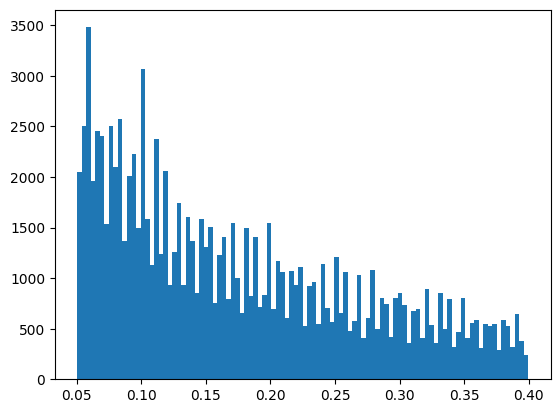

In [13]:
import matplotlib.pyplot as plt
plt.hist(df.contract_price, bins=100);

This suggests the data is multi-modal, which can be modelled as a mixture of distributions. In fact, instead of MDNs, we can also use a mixture of skewed distributions.

In [ ]:
MDN = trainMDN(train_ds, valid_ds)

Again, we can construct a confidence interval from the model. Note here the model outputs a `tfp.Distribution` instance which is a probability distribution.

In [ ]:
samples = MDN(sample_x).sample(30).numpy()
approx_mean = samples.mean(axis=-1)
apporx_var  = samples.var(axis=-1)
eps         = 1.96 * np.sqrt(apporx_var/30)

In [ ]:
print(f"The confidence interval is: {approx_mean - eps} to {approx_mean + eps}")

## 3 Ensemble of MDNs

This has not yet been implemented. The idea is that through the use of **bagging**, the different MDNs can learn the different modals in the data, thus they can be used together to give a better estimate.